In [12]:
import glob

import pandas as pd  # Dataframe manipulation
import seaborn as sns
import numpy as np

Load the data set for one participant

In [13]:
project_id = "RADAR-MDD-KCL-s1"
subject_id = "00d1d60a-15cf-481b-8264-91705b6f8d97"
data: pd.DataFrame = pd.concat(map(pd.read_csv, glob.glob(f"work/data/relative-location/"
                                                          f"{project_id}/{subject_id}/android_phone_relative_location"
                                                          f"/*.csv.gz")))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


Describe the dataset

In [14]:
description = data.describe()
description

,value.accuracy,value.altitude,value.bearing,value.latitude,value.longitude,value.offsetReference,value.speed,value.time,value.timeReceived
count,18693.000000,15907.000000,3002.000000,18693.000000,18693.000000,0.0,3002.000000,1.869300e+04,1.869300e+04
mean,177.273973,185.040835,175.994524,50.250645,-0.928588,NaN,0.110255,1.560726e+09,1.560728e+09
std,3586.356010,52.536599,117.136087,0.189800,0.937627,NaN,1.002164,4.201757e+06,4.200161e+06
min,0.800000,-117.100000,0.000000,48.258656,-2.148165,NaN,0.000000,1.554904e+09,1.554905e+09
25%,18.600000,158.900010,65.742500,50.056745,-2.070825,NaN,0.000000,1.556152e+09,1.556152e+09
50%,19.024000,226.900010,176.605000,50.383709,-0.159983,NaN,0.000000,1.561011e+09,1.561011e+09
75%,20.088000,227.700010,287.310000,50.383732,-0.159935,NaN,0.000000,1.564424e+09,1.564424e+09
max,488276.970000,239.100000,359.860000,51.122476,1.911010,NaN,18.469263,1.568155e+09,1.568155e+09


Data Pre processing. Remove any outliers. like very high accuracy values.
Drop columns that are not relevant and some time manipulations.

In [15]:
data_clean = data.drop(columns=['value.offsetReference', 'value.bearing', 'value.speed', 'value.timeReceived',
                                'key.projectId' , 'key.sourceId'])
data_clean = data_clean[
    data_clean['value.accuracy'] < 
    description['value.accuracy']['75%'] + description['value.accuracy']['50%']]
data_clean['value.accuracy'].filter()

data_clean = data_clean[data_clean['value.accuracy'] < 100]

def get_time_of_day(event_time, timezone_offset_in_seconds=0):
    if event_time is not None:
        event_time = pd.Timestamp(event_time, unit='s') + pd.Timedelta(seconds=timezone_offset_in_seconds)
        y = event_time - event_time.normalize()
        return y
    else:
        return np.NaN
# TODO: Get the timezone offset from application_timezone values
data_clean['value.timeOfDay'] = data_clean['value.time']\
    .apply(lambda x: get_time_of_day(x, 3600))

night_max_time_delta = pd.Timedelta(days=0, hours=6)
night_min_time_delta = pd.Timedelta(days=0, hours=0, minutes=1)
data_clean['value.isNight'] = data_clean['value.timeOfDay']\
    .apply(lambda x: night_max_time_delta > x >= night_min_time_delta)

data_clean.describe()

,value.accuracy,value.altitude,value.latitude,value.longitude,value.time,value.timeOfDay
count,15828.000000,15802.000000,15828.000000,15828.000000,1.582800e+04,15828
mean,16.383433,184.840961,50.233850,-1.011866,1.560381e+09,0 days 12:52:10.176734
std,6.203045,52.555233,0.181574,0.953406,4.193256e+06,0 days 06:54:19.981222
min,0.800000,-117.100000,48.258656,-2.148165,1.554904e+09,0 days 00:00:00.769999
25%,18.490750,158.900010,50.056743,-2.070834,1.556052e+09,0 days 07:45:13.342250
50%,18.913500,226.800000,50.383710,-0.159989,1.560455e+09,0 days 13:13:31.513000
75%,19.400000,227.700010,50.383729,-0.159943,1.564129e+09,0 days 18:37:59.612999
max,37.560000,229.600000,50.734809,1.911010,1.568155e+09,0 days 23:59:36


In [16]:
data_clean.dtypes


key.userId                  object
value.accuracy             float64
value.altitude             float64
value.latitude             float64
value.longitude            float64
value.provider              object
value.time                 float64
value.timeOfDay    timedelta64[ns]
value.isNight                 bool
dtype: object

In [17]:
data_clean.head()
data_clean[data_clean['value.isNight'] == True].count()

key.userId         2810
value.accuracy     2810
value.altitude     2810
value.latitude     2810
value.longitude    2810
value.provider     2810
value.time         2810
value.timeOfDay    2810
value.isNight      2810
dtype: int64

Find correlation between data and plot it as a heatmap

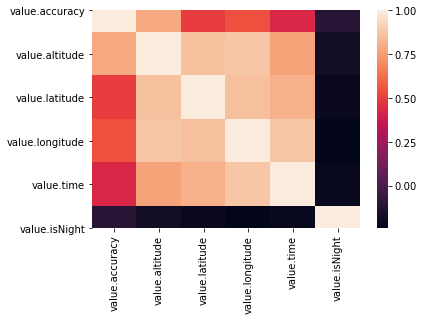

In [21]:
corr = data_clean.corr(method='pearson')
sns.heatmap(corr)

Plot it as a scatter plot colouring the isNight categorical variable.

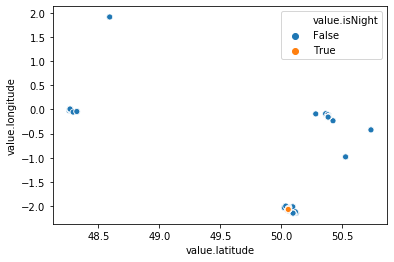

In [22]:
sns.scatterplot(data = data_clean, x = 'value.latitude', y = 'value.longitude', hue='value.isNight')

Do k-Means clustering with K=3 (Home, Work, Other)

In [23]:
from sklearn.cluster import KMeans

#K means Clustering 
def doKmeans(X: pd.DataFrame, nclust=2, sample_weight=None):
    model = KMeans(nclust)
    
    model.fit(X, sample_weight=sample_weight) if(weights is not None) else model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

weights = data_clean['value.isNight'].apply(lambda x: 500 if(x == True) else 1)
clust_labels, cent = doKmeans(data_clean[['value.latitude', 'value.longitude']], 3, weights)
kmeans = pd.DataFrame(clust_labels)
data_clean['kmeans'] = kmeans

Plot the clusters obtained using k-means

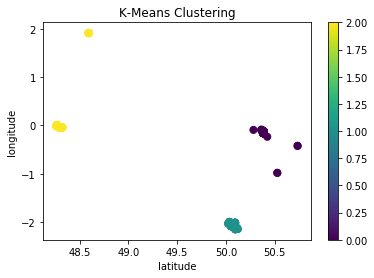

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_clean['value.latitude'],data_clean['value.longitude'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(scatter)